# Wildcard Handling with Astroquery.mast

----

## Learning Goals

By the end of this tutorial, you will:

* Learn about the wildcards available for `astroquery.mast.Observations` criteria queries
* Learn how to use these wildcards to broaden or refine `astroquery.mast.Observations` criteria queries
* Learn the downfalls of the `instrument_name` criteria, particularly for JWST queries
* Learn how to query for moving targets using target ephemeris and time criteria such as `t_min` and `t_max` for more advanced searches

## Introduction

This notebook will demonstrate the use of wildcards in `astroquery.mast.Observations` criteria queries. The use of wildcards is encouraged for certain criteria types (`string` object types) to ensure that your query results capture what is truly available on MAST. We will use 3 examples to demonstrate some use-cases for wildcards when doing criteria queries, and to emphasize on certain criteria where wildcard usage is highly encouraged, particularly for JWST queries. We will also use the last example to demonstrate the use of value ranges when working with `float` object criteria types.

The workflow for this notebook consists of:

* Wildcards with `astroquery.mast.Observations`
    * Wildcard Search with `instrument_name`
    * Wildcard Search with `instrument_name` and `proposal_id`
    * Wildcard Search a Time-sensitive Object with `target_name` and `t_min`
    * Resources

## Imports

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import Table, unique, vstack
from astropy.time import Time
from astroquery.mast import Observations

----

## Wildcards with `astroquery.mast.Observations`

The use of wildcards when making `astroquery.mast.Observations` queries can help ensure you retrieve all observations without leaving anything out. The available wildcards are `%` and `*` with `%` serving to replace a single character, and `*` serving to replace more than one character preceding, following, or in between the existing characters, depending on its placement. See the [Observation Criteria Queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries) section in the `astroquery.mast` documentation for more information on the wildcards.

With that being said, wildcards are only available for certain criteria. Those criteria that are `string` type objects are criteria that accept wildcards, but `float`, `integer`, or any other objects do not accept wildcards.

Users may call the `get_metadata` method to see the list of criteria that can be queried with. The criteria listed as `string` objects under the **Data Type** column are criteria that can be called with wildcards:

In [2]:
Observations.get_metadata("observations").show_in_notebook()

idx,Column Name,Column Label,Data Type,Units,Description,Examples/Valid Values
0,intentType,Observation Type,string,,Whether observation is for science or calibration.,"Valid values: science, calibration"
1,obs_collection,Mission,string,,Collection,"E.g. SWIFT, PS1, HST, IUE"
2,provenance_name,Provenance Name,string,,"Provenance name, or source of data","E.g. TASOC, CALSTIS, PS1"
3,instrument_name,Instrument,string,,Instrument Name,"E.g. WFPC2/WFC, UVOT, STIS/CCD"
4,project,Project,string,,Processing project,"E.g. HST, HLA, EUVE, hlsp_legus"
5,filters,Filters,string,,Instrument filters,"F469N, NUV, FUV, LOW DISP, MIRROR"
6,wavelength_region,Waveband,string,,Energy Band,"EUV, XRAY, OPTICAL"
7,target_name,Target Name,string,,Target Name,Ex. COMET-67P-CHURYUMOV-GER-UPDATE
8,target_classification,Target Classification,string,,Type of target,Ex. COMET;COMET BEING ORBITED BY THE ROSETTA SPACECRAFT;SOLAR SYSTEM
9,obs_id,Observation ID,string,,"Observation identifier, given by mission","U24Z0101T, N4QF18030"


### Wildcard Search with `instrument_name`

For our first example we will search for all NIRISS observations taken by a certain proposal/program PI. For this case, our two criteria we query with are `proposal_pi` and `instrument_name`, which are both `string` object criteria. As such, both can be wildcarded for ease of use. In fact, there may be cases where it is necessary to wildcard the `instrument_name` variable. This is because the JWST science instrument names on MAST have been modified to include configuration information for more precise advanced searches. However, this may lead to an incomplete list of observations returned for those who are not trying to do an advanced search. 

We will demonstrate this by looking at the results for the query below:

In [3]:
observations = Observations.query_criteria(proposal_pi="Espinoza, Nestor",
                                           instrument_name="*NIRISS*")
observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str7,str12,str4,str13,str8,str13,str1,str50,float64,float64,str8,str16,int64,float64,float64,float64,float64,float64,str70,float64,str4,str3,int64,str132,str63,str81,str6,bool,float64,str9,str9
science,JWST,CALJWST,NIRISS,JWST,F277W/GR700XD,Infrared,HAT-P-14,--,jw01541-o001_t002_niriss_f277w-gr700xd-substrip256,260.1161716666666,38.24216944444444,spectrum,"Espinoza, Nestor",3,59738.26121625,59738.55835982639,384.785,600.0,3200.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 260.16189536 38.23724946 260.11337073 38.23746108 260.11348004 38.24619441 260.16201403 38.24597997 260.16189536 38.23724946,--,mast:JWST/product/jw01541-o001_t002_niriss_f277w-gr700xd-substrip256_x1dints.fits,PUBLIC,False,nan,85715273,195816449
science,JWST,CALJWST,NIRISS/SOSS,JWST,F480M,INFRARED,BD+60-1753,--,jw01512002001_02101_00001_nis,261.2178643508574,60.43078346928282,image,"Espinoza, Nestor",2,59995.98101357639,59995.98102200231,0.683,4600.0,5000.0,SOSS Wavelength and Trace,59996.18175925,1512,CAL,--,POLYGON 261.218693113 60.429993446 261.216484201 60.430416356 261.217327028 60.431499222 261.219536203 60.431076276,mast:JWST/product/jw01512002001_02101_00001_nis_cal.jpg,mast:JWST/product/jw01512002001_02101_00001_nis_cal.fits,PUBLIC,False,nan,117933629,255695241
science,JWST,CALJWST,NIRISS/SOSS,JWST,F480M,INFRARED,BD+60-1753,--,jw01512002001_02101_00004_nis,261.2178643508749,60.43078346928948,image,"Espinoza, Nestor",2,59995.98740097222,59995.98740939815,0.683,4600.0,5000.0,SOSS Wavelength and Trace,59996.18133101,1512,CAL,--,POLYGON 261.218665628 60.430005149 261.21645672 60.430428066 261.21729956 60.431510929 261.219508731 60.431087978,mast:JWST/product/jw01512002001_02101_00004_nis_cal.jpg,mast:JWST/product/jw01512002001_02101_00004_nis_cal.fits,PUBLIC,False,nan,117933631,255695252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
science,JWST,CALJWST,NIRISS/SOSS,JWST,CLEAR;GR700XD,INFRARED,HAT-P-14,--,jw01541001001_04101_00001-seg004_nis,260.1161736742332,38.24216472053897,spectrum,"Espinoza, Nestor",2,59738.29788028935,59738.55248649306,18855.408,500.0,5000.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 260.16189736 38.23724474 260.11337274 38.23745635 260.11348205 38.24618969 260.16201603 38.24597525 260.16189736 38.23724474,mast:JWST/product/jw01541001001_04101_00001-seg004_nis_ramp.jpg,mast:JWST/product/jw01541001001_04101_00001-seg004_nis_x1dints.fits,PUBLIC,False,nan,85700141,257352626
science,JWST,CALJWST,NIRISS/SOSS,JWST,CLEAR;GR700XD,INFRARED,HAT-P-14,--,jw01541001001_04101_00001-seg003_nis,260.1161736742332,38.24216472053897,spectrum,"Espinoza, Nestor",2,59738.29788028935,59738.55248649306,18855.408,500.0,5000.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 260.16189736 38.23724474 260.11337274 38.23745635 260.11348205 38.24618969 260.16201603 38.24597525 260.16189736 38.23724474,mast:JWST/product/jw01541001001_04101_00001-seg003_nis_ramp.jpg,mast:JWST/product/jw01541001001_04101_00001-seg003_nis_x1dints.fits,PUBLIC,False,nan,85700237,257352647
science,JWST,CALJWST,NIRISS/SOSS,JWST,CLEAR;GR700XD,INFRARED,HAT-P-14,--,jw01541001001_04101_00001-seg002_nis,260.1161736742332,38.24216472053897,spectrum,"Espinoza, Nestor",2,59738.29788028935,59738.55248649306,18855.408,500.0,5000.0,NIRISS Sensitivity and Stability for Transiting Exoplanet Observations,59774.8541666,1541,COM,--,POLYGON 260.16189736 38.23724474 260.11337274 38.23745635 2

Here we have a list of all kinda of NIRISS observations led by the PI Dr. Espinoza. Let's call for all the unique values under the `instrument_name` column to see what was returned thanks to our `*` wildcards.

In [4]:
set(observations['instrument_name'])

{'NIRISS', 'NIRISS/IMAGE', 'NIRISS/SOSS'}

As you can see, there were some observations with `instrument_name` labeled something other than `NIRISS`, due to the new configuration on MAST. Had we only searched for the `instrument_name` value `NIRISS`, we would have missed several observations. For the full list of instrument name variations, you can refer to [this page](https://outerspace.stsci.edu/display/MASTDOCS/JWST+Instrument+Names).

**Note**: Be aware that you can be too generous with the wildcards. Too much ambiguity will lead to getting results that were not intended. See below for example.

In [5]:
observations = Observations.query_criteria(proposal_pi='Espinoza, Nestor',
                                           instrument_name='*NI*S*')
set(observations['instrument_name'])

{'NIRISS', 'NIRISS/IMAGE', 'NIRISS/SOSS', 'NIRSPEC/SLIT'}

This query returns `NIRSPEC/SLIT` observations in addition to the NIRISS ones, which is not what was intended.

### Wildcard Search with `instrument_name` and `proposal_id`

Let's repeat the previous example, but add another `string` criteria and wildcard into the mix. Let's query for all observations belonging to proposal/program IDs that begin with the digits `15`, and see what gets returned:

In [6]:
observations = Observations.query_criteria(proposal_pi='Espinoza, Nestor',
                                           instrument_name='*NIRISS*',
                                           proposal_id=['15%%'])
set(observations['proposal_id']), set(observations['instrument_name'])

({'1512', '1541'}, {'NIRISS', 'NIRISS/IMAGE', 'NIRISS/SOSS'})

### Create a Moving Target Ephemeris using MAST Observations with Wildcard Search

We will be querying for image observations of Comet 67P Churyumov-Gerasimenko observed through the Hubble Space Telescope's Advanced Camera for Surveys (ACS) Wide Field Camera (WFC). This comet's name can be listed in different ways, so we will use `*` wildcards in our criteria query. For this case, we won't use any wildcards in the `instrument_name` because we don't run into many variations of HST instrument names the way we do for JWST.

In [7]:
observations = Observations.query_criteria(target_name="*COM*67P*",
                                           instrument_name="ACS/WFC")

print(f"{len(observations)} total observations" + "\n")
print("Listed target names:")
print(set(observations['target_name']))

140 total observations

Listed target names:
{'COMET-67P-CHURYUMOV-GERASIMENK', 'COMET-67P-CHURYUMOV-GER-UPDATE'}


Above you can see there are two type of observations we get for Comet-67P, and this query yields a total of 140 observations. The `target_name` criteria is not always the most reliable way to retrieve all desired observations, as it runs into the same pitfalls that `instrument_name` has, where there are multiple names for the same object. In the remainder of this notebook, we will construct a bare-bones ephemeris using the filtered MAST observations of this object and their metadata. We will then do some reverse engineering to query for the target based on coordinates using the ephemeris table, and hope that we get the same results back! Let's begin:

For simplicity, let's work only with the `'COMET-67P-CHURYUMOV-GERASIMENK'` observations to create our ephemeris.

In [8]:
mask = observations["target_name"] == "COMET-67P-CHURYUMOV-GERASIMENK"
filtered_observations = observations[mask]
filtered_observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str3,str6,str7,str3,str12,str7,str30,str89,str36,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str119,float64,str5,str3,int64,str2243,str86,str35,str6,bool,float64,str8,str9
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET BEING ORBITED BY THE ROSETTA SPACECRAFT,jcz303010,149.386341824,17.6965860963,image,"Hines, Dean C.",3,57306.530825775466,57306.56028197917,1868.0,470.0,720.0,Post-Perihelion Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Continued Support of the Rosetta Mission,57672.72732635,14261,GO,--,POLYGON 149.42419008 17.69882864 149.419199178432 17.700727169054169 149.41933345 17.70098796 149.41339666747842 17.703246092045436 149.41340981 17.70327162 149.38611359 17.71365103 149.3854302694572 17.712323331878636 149.37931127 17.71464943 149.36605771 17.68889173 149.39335114 17.67851501 149.39388702876451 17.679556324023046 149.41093132 17.67307379 149.42419008 17.69882864 149.42419008 17.69882864,mast:HST/product/jcz303010_drz.jpg,mast:HST/product/jcz303010_drz.fits,PUBLIC,True,nan,25001892,220778619
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis06020,290.9147892768,-27.90546497065,image,"Hines, Dean C.",3,56979.51550486111,56979.66734533565,6280.0,470.0,720.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57344.94447902,13863,GO,--,POLYGON -69.051552329999993 -27.91547868 -69.051566623053915 -27.915304522529482 -69.048023170000022 -27.91483611 -69.048086300262 -27.914066875478145 -69.045198070000026 -27.91368501 -69.045253211462011 -27.913013321787403 -69.031596869999987 -27.91120688 -69.031681552501226 -27.910176912272057 -69.027714189999983 -27.90965175 -69.02772849552359 -27.909477898544647 -69.024182240000016 -27.90900847 -69.02653583 -27.88039823 -69.057861839999987 -27.88454222 -69.057847539106191 -27.884716718646743 -69.06139399 -27.88518549 -69.06130963442007 -27.88621477953863 -69.065275460000009 -27.88673877 -69.0652204552501 -27.887410472053556 -69.078874509999991 -27.8892136 -69.078813220742 -27.889963190045712 -69.098235400000021 -27.89252561 -69.098220005459254 -27.892714303389873 -69.102038349999987 -27.89321784 -69.099703449999993 -27.92182943 -69.082889846828763 -27.919611642662879 -69.082889340000008 -27.91961784 -69.051552329999993 -27.91547868 -69.051552329999993 -27.91547868,mast:HST/product/jcis06020_drz.jpg,mast:HST/product/jcis06020_drz.fits,PUBLIC,True,nan,24839236,221276308
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis04020,290.2770693515,-28.02111499969,image,"Hines, Dean C.",3,56977.45820188658,56977.611049039355,6280.0,470.0,720.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57342.94112256,13863,GO,--,POLYGON -69.68999134 -28.03180292 -69.690000793261078 -28.0314964187349 -69.68653658 -28.03117872 -69.686564584120333 -28.03027073277142 -69.683764119999978 -28.03001384 -69.6838006065022 -28.028831798853574 -69.67044575 -28.02760593 -69.670481996731183 -28.026436279688706 -69.666591489999973 -28.02607881 -69.666601003399478 -28.025772506303237 -69.663133870000024 -28.02545393 -69.664023900000018 -27.99678969 -69.695551850000015 -27.99968392 -69.695542411269713 -27.999990871866526 -69.69900966 -28.0003088 -69.6989737114984 -28.001477839264155 -69.702862620000019 -28.00183422 -69.702826356326327 -28.00301616323647 -69.716178

Now that we have our filtered observations, let's sort the rows of this table based on the `t_min` criteria, which refers to the start time of the exposure in MJD.

In [9]:
filtered_observations.sort("t_min")

Now that we've sorted our table, let's construct a basic ephemeris showing the path of our object over time (with `t_min`, or exposure start in MJD, as our time component):

In [10]:
ephemeris = Table([filtered_observations["s_ra"],
                   filtered_observations["s_dec"],
                   filtered_observations["t_min"]], names=("ra", "dec", "t_min"))

Let's display the contents of our ephemeris, and use it to generate a plot of the comet's path:

In [11]:
ephemeris.sort("t_min")
ephemeris.show_in_notebook()

idx,ra,dec,t_min
0,281.2558788729,-31.01619293249,56887.26573422454
1,281.1070408364967,-31.006679797131913,56888.26101
2,281.1070302812,-31.0066887554,56888.26101200232
3,281.1045408863173,-31.00650879708346,56888.27707
4,281.0975108367455,-31.006933797314236,56888.32419
5,281.0951608865579,-31.006770747268593,56888.34025
6,281.0868808868347,-31.005851797486205,56888.39054
7,281.0845408866453,-31.005687797434355,56888.40661
8,281.0773208868312,-31.004271747618215,56888.4569
9,281.0749808366519,-31.004106747569107,56888.47296


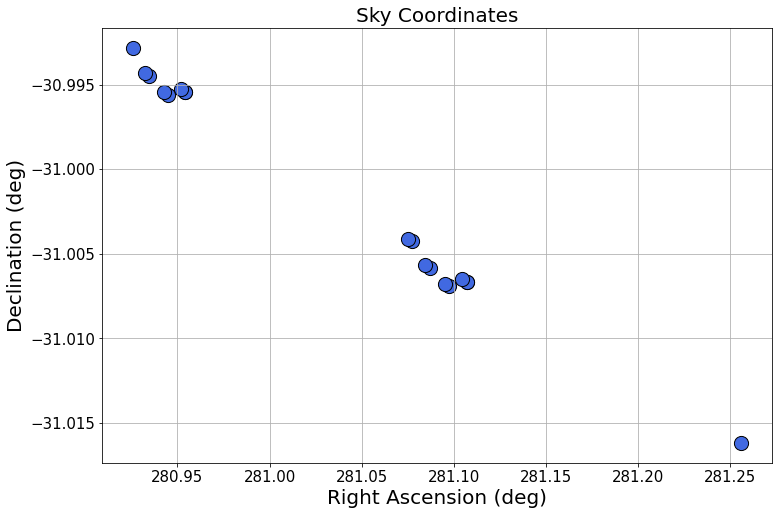

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(ephemeris[0:18]['ra'], ephemeris[0:18]['dec'], color='royalblue', s=200, lw=1., edgecolor='k')

plt.xlabel("Right Ascension (deg)", fontsize=20)
plt.ylabel("Declination (deg)", fontsize=20)

plt.title("Sky Coordinates", fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

Lastly, let's do some reverse engineering and use the RA, Declination, and `t_min` values from the ephemeris to query for observations of the comet once again, and ensure that no observations were missed using the `*` wildcard from the previous criteria query for this example. Be aware that the following cell may take a little longer to run:

In [13]:
tables = []

for row in ephemeris:
    ra, dec, t_min = row["ra"], row["dec"], row["t_min"]
    coords = f'{ra} {dec}'
    observations = Observations.query_criteria(coordinates=coords,
                                               target_name="COMET-67P-CHURYUMOV-GERASIMENK",
                                               instrument_name="ACS/WFC",
                                               t_min=[t_min-1, t_min+1])

    tables.append(observations)

In [14]:
ephemeris_observations = unique(vstack(tables), keys="t_min")
ephemeris_observations

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str3,str6,str7,str3,str12,str7,str30,str89,str36,float64,float64,str5,str14,int64,float64,float64,float64,float64,float64,str119,float64,str5,str3,int64,str1191,str86,str35,str6,bool,float64,str8,str9,str9,float64
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis01010,281.2558788729,-31.01619293249,image,"Hines, Dean C.",3,56887.26573422454,56887.49156755787,7200.0,470.0,720.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57252.60829852,13863,GO,--,POLYGON -78.756865950000019 -31.03386473 -78.72529176 -31.02670072 -78.731368569999972 -30.9985026 -78.733805750513454 -30.9990559361688 -78.733958120000011 -30.99834869 -78.740986132787157 -30.99994418656815 -78.741227330000015 -30.9988241 -78.743523208857965 -30.999345171906345 -78.743666940000026 -30.9986777 -78.751640936670128 -31.000487279621648 -78.752215089999993 -30.99781954 -78.754505385727953 -30.998339146989291 -78.75464896 -30.99767203 -78.761518775521665 -30.999230471627669 -78.762147550000009 -30.99630741 -78.764432262131379 -30.996825567137762 -78.764575690000015 -30.99615878 -78.796142359999976 -31.00331385 -78.79008367 -31.03151488 -78.787798738721818 -31.030997298944033 -78.787655570000027 -31.0316635 -78.780782261578381 -31.030106426334836 -78.780153620000021 -31.03303019 -78.777863106729612 -31.032511160972405 -78.777719789999992 -31.0331777 -78.769741953915457 -31.031369732821123 -78.76916795 -31.03403788 -78.766871853092809 -31.033517388181245 -78.766728380000018 -31.03418428 -78.759696670679176 -31.032590149820496 -78.759455460000027 -31.03371081 -78.757018048375642 -31.033158086745466 -78.756865950000019 -31.03386473 -78.756865950000019 -31.03386473,mast:HST/product/jcis01010_drz.jpg,mast:HST/product/jcis01010_drz.fits,PUBLIC,True,nan,24839228,221298099,221298099,0.0
science,HLA,HLA,ACS/WFC,HLA,F606WPOL60V,--,COMET-67P-CHURYUMOV-GERASIMENK,--,hst_13863_02_acs_wfc_f606wpol60v_05,281.1070408364967,-31.006679797131913,image,Hines,2,56888.26101,56888.27492,1200.0,nan,nan,--,57253.60605318,13863,HLA,--,POLYGON J2000 281.11999810 -30.98912410 281.08836300 -30.99599530 281.09407880 -31.02423420 281.12572290 -31.01736150 281.11999810 -30.98912410,https://hla.stsci.edu/cgi-bin/preview.cgi?dataset=hst_13863_02_acs_wfc_f606wpol60v_05,--,PUBLIC,--,nan,25981096,67948363,67948363,401.58691953839383
science,HST,CALACS,ACS/WFC,HST,F606W,Optical,COMET-67P-CHURYUMOV-GERASIMENK,COMET; COMET-67P-CHURYUMOV-GERASIMENKO WHICH IS THE PRIMARY TARGET FOR ROSETTA SPACECRAFT,jcis02010,281.1070302812,-31.0066887554,image,"Hines, Dean C.",3,56888.26101200232,56888.48685717593,9600.0,470.0,720.0,Imaging Polarimetry of the 67P/Churyumov-Gerasimenko with ACS: Supporting the Rosetta Mission,57253.60605318,13863,GO,--,POLYGON -78.905924930000026 -31.02423579 -78.87427893 -31.0173634 -78.8800066 -30.98912327 -78.882365737150309 -30.989635932676503 -78.882504439999991 -30.98895186 -78.889317083503954 -30.990432181918216 -78.889530770000022 -30.98937778 -78.891752852813568 -30.989860489154527 -78.891883689999986 -30.98921489 -78.899628421871924 -30.990897116662392 -78.9001551 -30.98829685 -78.902371489060187 -30.988778129799261 -78.90250218 -30.98813288 -78.909141342406116 -30.989574421562239 -78.909719680000023 -30.98671762 -78.911930371781551 -30.987197501880228 -78.91206093 -30.98655257 -78.943699260000017 -30.99341636 -78.937989440000024 -31.02165911 -78.935778550730731 -31.021179788693974 -78.935648239999978 -31.02182416 -78.929005954826081 -31.020383985804244 -7

In [15]:
ephemeris_observations.sort("t_min")
filtered_observations.sort("t_min")
ephemeris_observations["t_min"] == filtered_observations["t_min"]

masked_array(data=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True],
             mask=False,
       fill_value=True)

Here we can see that there are no rows in the new `ephemeris_observations` table that don't match the original query results (`filtered_observations`), so the wildcard did catch all observations for Comet 67P.

## Resources

The following is a list of resources that were referenced throughout the tutorial, as well as some additional references that you may find useful:

* [`astroquery.mast.Observation` criteria queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html#observation-criteria-queries)
* [JWST Instrument Names](https://outerspace.stsci.edu/display/MASTDOCS/JWST+Instrument+Names)

## Citations

If you use any of astroquery's tools for published research, please cite the authors. Follow this link for more information about citing astroquery:

* [Citing astroquery](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)

## About This Notebook

If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at archive@stsci.edu. <br>
<br>
Author(s): Jenny V. Medina <br>
Keyword(s): Tutorial, astroquery, wildcards, moving, target <br>
Last Updated: Jun 2023